# Анализ продаж аудиотехники
## 1. Подготовка данных
Загрузка библиотек для анализа данных и визуализации.

In [17]:
# Импорт библиотек

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### 1.1 Сбор данных из файловой структуры

In [18]:
# Определение пути к данным
way = os.getcwd() + '/data'

# Инициализация списков для путей к файлам
file_paths_orders = []
file_paths_order_status = []
file_paths_products = []

# Обход структуры папок и сбор путей к CSV-файлам
for path, dirs, files in os.walk(way):
    for file in files:
        if file.endswith('.csv'):
            if file.startswith('products'):
                file_paths_products.append(os.path.join(path, file))
            elif file.startswith('order_'):
                file_paths_order_status.append(os.path.join(path, file))
            else:
                file_paths_orders.append(os.path.join(path, file))

### 1.2 Формирование основных датафреймов

In [30]:
# Создание датафрейма заказов
df_orders = pd.DataFrame()
for path in file_paths_orders:
    data = pd.read_csv(path)
    data['manager'] = path.split('/')[-2]
    data['date'] = path.split('/')[-3]
    df_orders = pd.concat([df_orders, data], axis=0, ignore_index=True)
df_orders = df_orders.sort_values(by=['order_id', 'product_id'])

# Создание датафрейма статусов
df_order_status = pd.DataFrame()
for path in file_paths_order_status:
    data = pd.read_csv(path)
    df_order_status = pd.concat([df_order_status, data], axis=0, ignore_index=True)
df_order_status = df_order_status.sort_values(by='order_id')

# Создание датафрейма товаров
df_products = pd.DataFrame()
for path in file_paths_products:
    data = pd.read_csv(path)
    data['category'] = path.split('/')[-2]
    df_products = pd.concat([df_products, data], axis=0, ignore_index=True)
df_products = df_products.sort_values(by='id')

# Сохранение промежуточных данных
df_orders.to_csv('df_orders.csv', index=False)
df_order_status.to_csv('df_order_status.csv', index=False)
df_products.to_csv('df_products.csv', index=False)

### 1.3 Объединение данных для анализа

In [31]:
# Объединение данных о заказах и статусах
orders_status = df_orders.merge(df_order_status, on='order_id')

# Подсчет подтвержденных и отмененных заказов
confirmed_orders = orders_status.loc[orders_status.status == 'confirmed'].order_id.nunique()
canceled_orders = orders_status.loc[orders_status.status == 'canceled'].order_id.nunique()
part_of_canceled_orders = canceled_orders / (confirmed_orders + canceled_orders)

print(f"Подтвержденных заказов: {confirmed_orders}")
print(f"Отмененных заказов: {canceled_orders}")
print(f"Доля отмененных заказов: {round(part_of_canceled_orders, 2)}")

Подтвержденных заказов: 309
Отмененных заказов: 37
Доля отмененных заказов: 0.11


## 2. Анализ временных паттернов
### 2.1 Анализ заказов по дням

День с максимальным количеством заказов: 2024-03-14
Количество заказов в этот день: 34


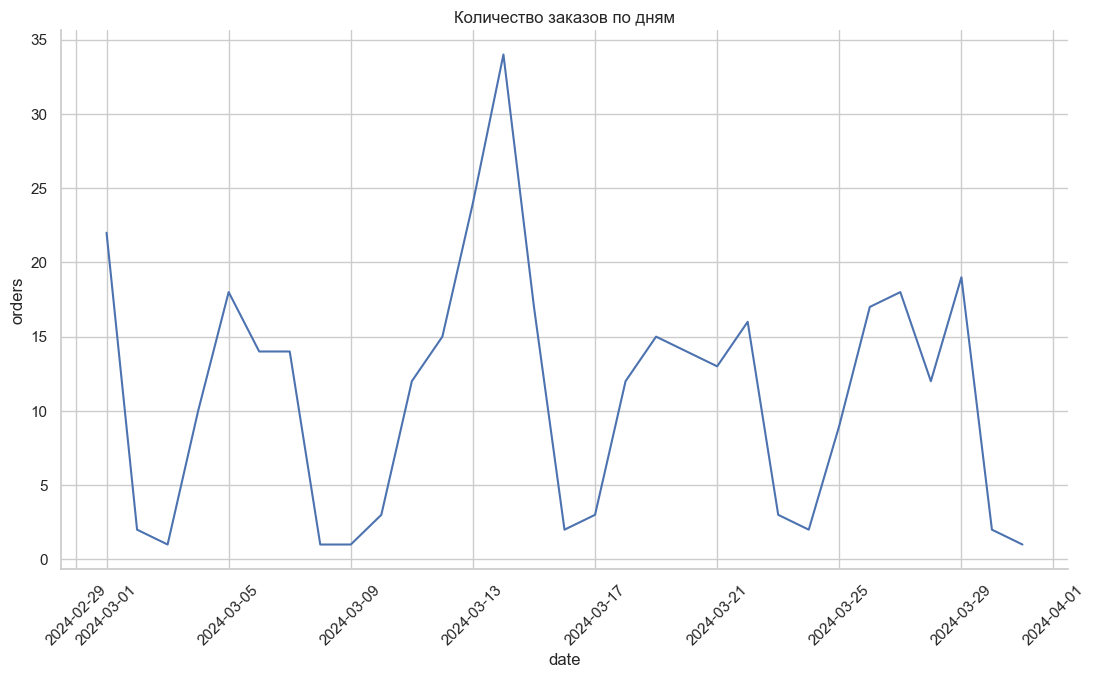

In [32]:
# Преобразование даты и анализ по дням
df_orders['date'] = pd.to_datetime(df_orders['date'])
daily_orders = df_orders.groupby('date')['order_id'].nunique().reset_index()
daily_orders = daily_orders.rename(columns={'order_id': 'orders'})

# День с максимальным количеством заказов
result_date = daily_orders.sort_values('orders', ascending=False).iloc[0]['date']
result_date_str = result_date.strftime('%Y-%m-%d')

print(f"День с максимальным количеством заказов: {result_date_str}")
print(f"Количество заказов в этот день: {daily_orders[daily_orders.date == result_date]['orders'].values[0]}")

# Визуализация
sns.set(style='whitegrid', rc={'figure.figsize':(13,7)})
sns.lineplot(data=daily_orders, x='date', y='orders')
plt.xticks(rotation=45)
plt.title('Количество заказов по дням')
plt.minorticks_on()
sns.despine()

### 2.2 Анализ статусов заказов по дням

День без подтвержденных заказов: 2024-03-09


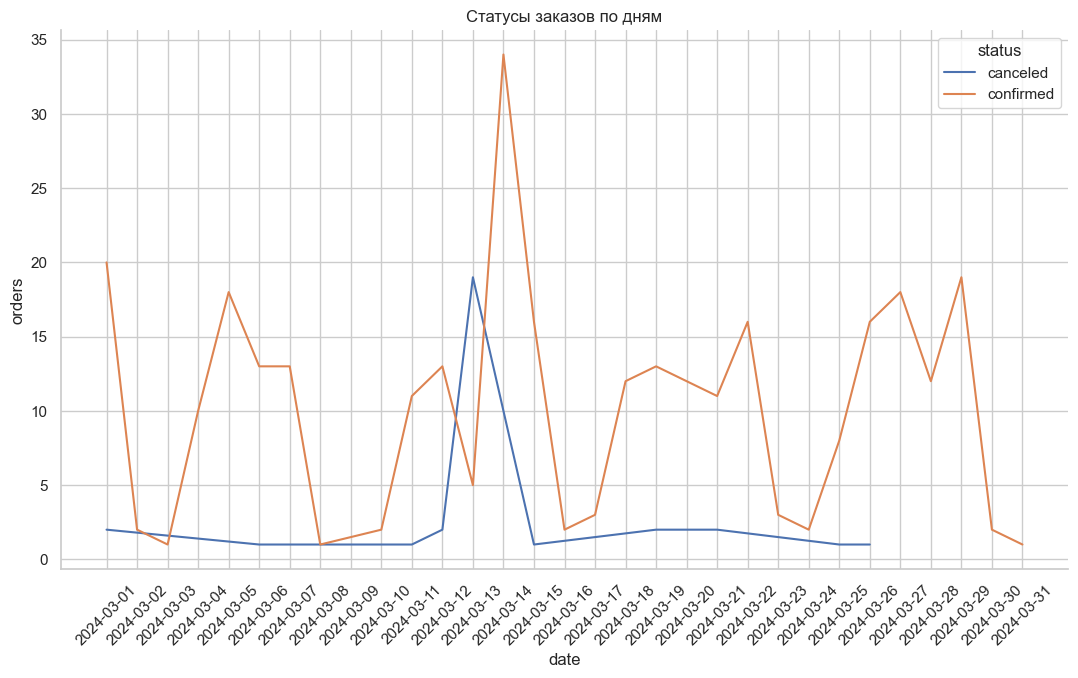

In [34]:
# Создание сводной таблицы по статусам
orders_status_unique = orders_status.groupby(['date', 'status']).order_id.nunique().reset_index()
orders_status_unique = orders_status_unique.rename(columns={'order_id': 'orders'})

orders_status_pivot = orders_status_unique.pivot(columns='status', index='date', values='orders').fillna(0)
orders_status_pivot.canceled = orders_status_pivot.canceled.apply(lambda x: int(x))
orders_status_pivot.confirmed = orders_status_pivot.confirmed.apply(lambda x: int(x))

# День без подтвержденных заказов
no_confirmed_day = orders_status_pivot[orders_status_pivot['confirmed'] == 0].index[0]
print(f"День без подтвержденных заказов: {no_confirmed_day}")

# Визуализация статусов
sns.lineplot(data=orders_status_unique, x='date', y='orders', hue='status')
plt.title('Статусы заказов по дням')
plt.xticks(rotation=45)
sns.despine()


### 2.3 Исследование аномальных дней

In [35]:
# Добавление названия дня недели для анализа
daily_orders['day_name'] = daily_orders.date.dt.day_name()

# Проверка гипотез об аномальных днях
print("Проверка воскресных заказов:")
print(daily_orders.loc[daily_orders.day_name == 'Sunday'])

print("\nПроверка понедельничных заказов:")
print(daily_orders.loc[daily_orders.day_name == 'Monday'])

print("\nПроверка пятничных заказов:")
print(daily_orders.loc[daily_orders.day_name == 'Friday'])

Проверка воскресных заказов:
         date  orders day_name
2  2024-03-03       1   Sunday
9  2024-03-10       3   Sunday
16 2024-03-17       3   Sunday
23 2024-03-24       2   Sunday
30 2024-03-31       1   Sunday

Проверка понедельничных заказов:
         date  orders day_name
3  2024-03-04      10   Monday
10 2024-03-11      12   Monday
17 2024-03-18      12   Monday
24 2024-03-25       9   Monday

Проверка пятничных заказов:
         date  orders day_name
0  2024-03-01      22   Friday
7  2024-03-08       1   Friday
14 2024-03-15      17   Friday
21 2024-03-22      16   Friday
28 2024-03-29      19   Friday


In [36]:
# Анализ двух смежных дней с аномальной активностью
orders_14 = orders_status.loc[(orders_status.date == '2024-03-13')].copy()
orders_13 = orders_status.loc[(orders_status.date == '2024-03-14')].copy()

# Поиск повторяющихся заказов
same_orders = orders_13.merge(orders_14, on=['client_id', 'manager', 'product_id', 'quantity'])

print(f"Заказов 13 марта: {orders_14.order_id.nunique()}")
print(f"Заказов 14 марта: {orders_13.order_id.nunique()}")
print(f"Повторяющихся заказов: {same_orders.order_id_x.nunique()}")
print(f"Доля повторений: {same_orders.order_id_x.nunique()/orders_14.order_id.nunique():.0%}")

Заказов 13 марта: 24
Заказов 14 марта: 34
Повторяющихся заказов: 16
Доля повторений: 67%


## 3. Финансовый анализ
### 3.1 Обработка валютных курсов

In [37]:
# Загрузка данных курса доллара
with open('usd_rate.txt', 'r', encoding='utf-8') as file:
    currency = file.readlines()

# Создание датафрейма курсов
df_usd_rate = (
    pd.DataFrame({'currency': currency})
    .currency.str.split(',', expand=True)
    .rename(columns={0: 'date', 1: 'currency_rate'})
    .drop(2, axis=1)
)

# Преобразование типов данных
df_usd_rate['date'] = pd.to_datetime(df_usd_rate['date'])
df_usd_rate['currency_rate'] = df_usd_rate['currency_rate'].astype(float)

# Расчет среднего курса
mean_currency = df_usd_rate.currency_rate.mean().round(2)
print(f"Средний курс доллара за месяц: {mean_currency}")

Средний курс доллара за месяц: 91.7


### 3.2 Расчет выручки и ключевых метрик

In [40]:
# Подготовка данных для расчета выручки
df_products = df_products.rename(columns={'id': 'product_id'})
df_orders_with_products = orders_status.merge(df_products, on='product_id')

orders_status['date'] = pd.to_datetime(orders_status['date'])
df_orders_with_products['date'] = pd.to_datetime(df_orders_with_products['date'])
df_full = df_orders_with_products.merge(df_usd_rate, on='date')

# Расчет выручки
df_full['revenue'] = df_full['currency_rate'] * df_full['price'] * df_full['quantity']

# Фильтрация подтвержденных заказов
df_confirmed = df_full.loc[df_full['status'] == 'confirmed']

# Расчет общей выручки и среднего чека
full_revenue = df_confirmed['revenue'].sum().round(2)
amount_of_orders = df_confirmed['order_id'].nunique()
average_bill = round(full_revenue / amount_of_orders, 2)

print(f"Общая выручка за месяц: {full_revenue:,.2f} рублей")
print(f"Количество подтвержденных заказов: {amount_of_orders}")
print(f"Средний чек: {average_bill:,.2f} рублей")

Общая выручка за месяц: 2,038,231,821.56 рублей
Количество подтвержденных заказов: 309
Средний чек: 6,596,219.49 рублей


### 3.3 Анализ динамики метрик

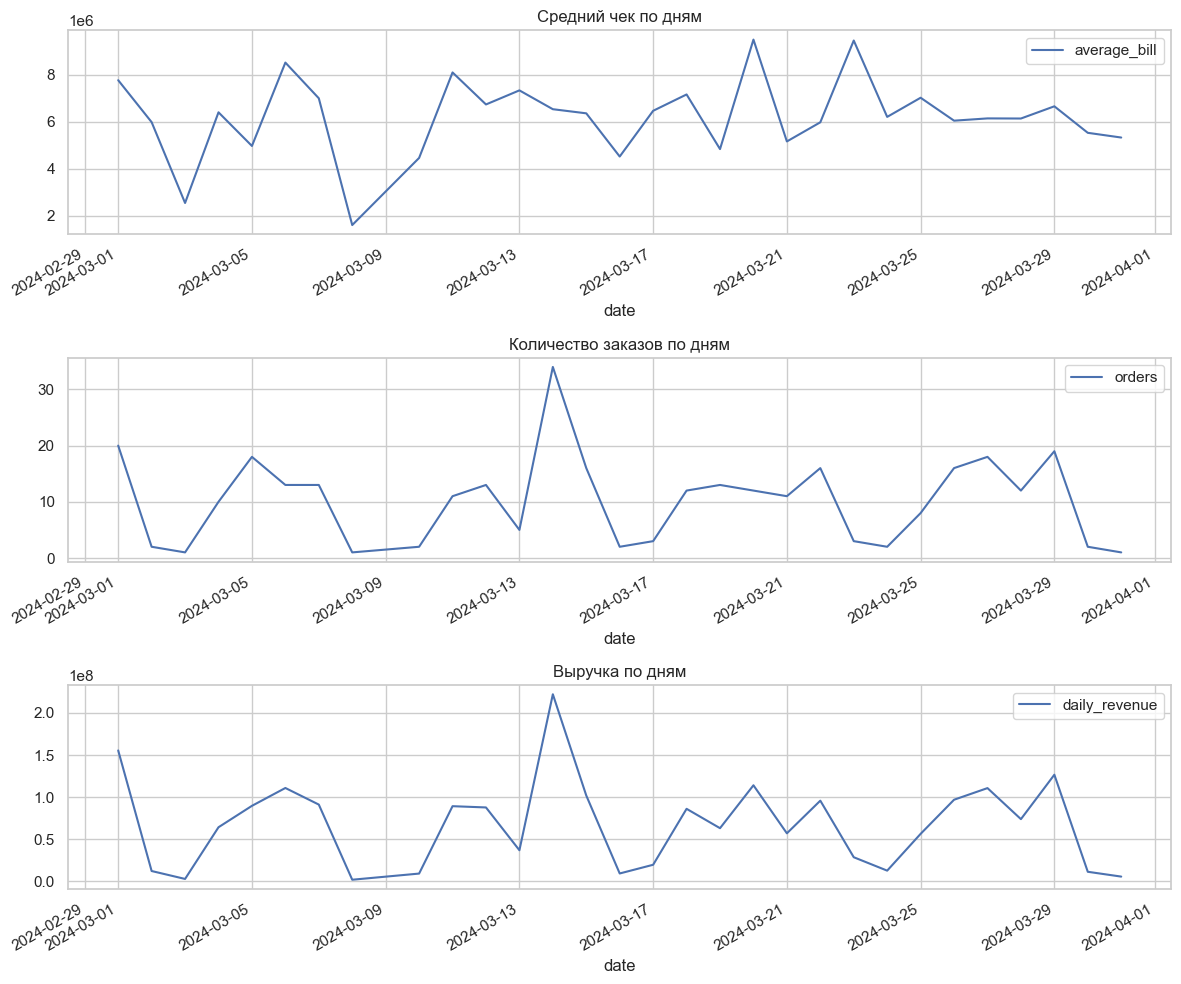

In [41]:
# Агрегация данных по дням
confirmed_per_day = (
    df_confirmed[['date', 'revenue', 'order_id']]
    .groupby(['date'], as_index=False)
    .agg({'revenue': 'sum', 'order_id': 'nunique'})
    .rename(columns={'order_id': 'orders', 'revenue': 'daily_revenue'})
    .assign(average_bill=lambda x: x['daily_revenue'] / x['orders'])
)

confirmed_per_day[['daily_revenue', 'average_bill']] = confirmed_per_day[['daily_revenue', 'average_bill']].round(2)

# Визуализация
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
confirmed_per_day.plot('date', 'average_bill', ax=axes[0], title='Средний чек по дням')
confirmed_per_day.plot('date', 'orders', ax=axes[1], title='Количество заказов по дням')
confirmed_per_day.plot('date', 'daily_revenue', ax=axes[2], title='Выручка по дням')
plt.tight_layout()

## 4. Анализ товаров и брендов
### 4.1 Анализ выручки по брендам

In [43]:
# Извлечение брендов из названий товаров
df_full['brand'] = df_full['name'].apply(lambda x: x.split(',')[0])

In [46]:
# Анализ брендов по выручке
brand_revenue = (
    df_full.loc[df_full.status == 'confirmed'].\
    groupby('brand', as_index=False).\
    agg({'revenue': 'sum', 'order_id': 'nunique'}).\
    sort_values(by='revenue', ascending=False).\
    rename(columns={'order_id': 'orders', 'revenue': 'brand_revenue'})
)

print("Топ-5 брендов по выручке:")
print(brand_revenue.head())

# Самый прибыльный бренд
top_brand = brand_revenue.iloc[0]
print(f"\nСамый прибыльный бренд: {top_brand['brand']}")
print(f"Выручка: {top_brand['brand_revenue']:,.2f} рублей")
print(f"Количество заказов: {top_brand['orders']}")

Топ-5 брендов по выручке:
       brand  brand_revenue  orders
46       JBL   2.665961e+08     264
43      Heco   2.388163e+08     229
53   Klipsch   2.039024e+08     205
120   Yamaha   1.658651e+08     218
49       KEF   1.465101e+08      73

Самый прибыльный бренд: JBL
Выручка: 266,596,053.10 рублей
Количество заказов: 264


### 4.2 Анализ невостребованных товаров

In [47]:
# Определение заказанных товаров
unique_products = df_confirmed['product_id'].unique()
df_products['is_in_orders'] = df_products['product_id'].apply(lambda x: 'yes' if x in unique_products else 'no')

# Статистика
ordered_stats = df_products['is_in_orders'].value_counts()
print(f"Заказанные товары: {ordered_stats.get('yes', 0)}")
print(f"Незаказанные товары: {ordered_stats.get('no', 0)}")
print(f"Доля невостребованных товаров: {ordered_stats.get('no', 0) / len(df_products):.1%}")

# Анализ по брендам
df_products['brand'] = df_products['name'].apply(lambda x: x.split(',')[0])
brand_analysis = (
    df_products.groupby(['brand', 'is_in_orders'], as_index=False)['product_id']
    .count()
    .rename(columns={'product_id': 'products'})
)

brand_analysis['total_by_brand'] = brand_analysis.groupby('brand')['products'].transform('sum')
brand_analysis['unused_ratio'] = brand_analysis['products'] / brand_analysis['total_by_brand']

# Бренды с высокой долей невостребованных товаров
high_unused = brand_analysis[
    (brand_analysis['is_in_orders'] == 'no') &
    (brand_analysis['total_by_brand'] > 15) &
    (brand_analysis['unused_ratio'] > 0.5)
]

print("\nБренды с высокой долей невостребованных товаров:")
for _, row in high_unused.iterrows():
    print(f"- {row['brand']}: {row['unused_ratio']:.1%} невостребованных товаров")

Заказанные товары: 1180
Незаказанные товары: 497
Доля невостребованных товаров: 29.6%

Бренды с высокой долей невостребованных товаров:
- Dali: 73.1% невостребованных товаров
- KEF: 65.9% невостребованных товаров
- Marantz: 86.4% невостребованных товаров
- Pioneer: 68.0% невостребованных товаров


## 5. Анализ эффективности менеджеров

Рейтинг менеджеров по доле выручки:


,manager,orders,manager_revenue,revenue_share,orders_share
9,Маргарита Камертонова,48,3.473886e+08,17.04,15.53
4,Виктор Тромбонов,50,3.188999e+08,15.65,16.18
8,Максим Барабанов,40,2.401478e+08,11.78,12.94
5,Владимир Ударников,31,2.084865e+08,10.23,10.03
0,Алексей Саксофонов,27,1.953435e+08,9.58,8.74
7,Ксения Балалайкина,27,1.817621e+08,8.92,8.74
6,Екатерина Тарелкина,28,1.781576e+08,8.74,9.06
10,Надежда Гармошкина,21,1.347836e+08,6.61,6.80
1,Анастасия Дудкина,20,1.234504e+08,6.06,6.47
2,Антон Скрипкин,7,5.150268e+07,2.53,2.27


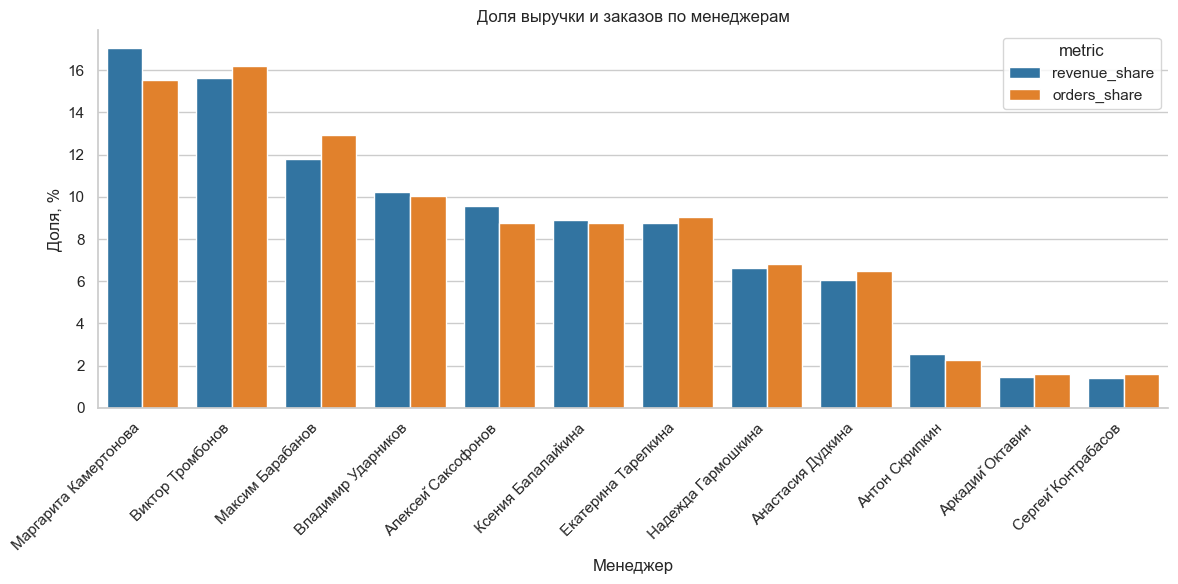

In [49]:
# Расчет метрик по менеджерам
confirmed_by_manager = (
    df_full.loc[df_full.status == 'confirmed']
    .groupby('manager', as_index=False)
    .agg({'order_id': 'nunique', 'revenue': 'sum'})
    .rename(columns={'order_id': 'orders', 'revenue': 'manager_revenue'})
)

# Расчет процентных долей
confirmed_by_manager['revenue_share'] = round(
    confirmed_by_manager['manager_revenue'] / confirmed_by_manager['manager_revenue'].sum() * 100, 2
)
confirmed_by_manager['orders_share'] = round(
    confirmed_by_manager['orders'] / confirmed_by_manager['orders'].sum() * 100, 2
)

# Сортировка по выручке
confirmed_by_manager = confirmed_by_manager.sort_values('revenue_share', ascending=False)

print("Рейтинг менеджеров по доле выручки:")
display(confirmed_by_manager)


# Визуализация
melted_data = pd.melt(
    confirmed_by_manager,
    id_vars=['manager'],
    value_vars=['revenue_share', 'orders_share'],
    var_name='metric',
    value_name='value'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_data, x='manager', y='value', hue='metric', palette=['#1f77b4', '#ff7f0e'])
plt.xticks(rotation=45, ha='right')
plt.title('Доля выручки и заказов по менеджерам')
plt.ylabel('Доля, %')
plt.xlabel('Менеджер')
sns.despine()
plt.tight_layout()